# Final Project - Deliverable 5
## Team 5 : Manish Walia, Priyanka Karia, Shyam Mohan

### Description: This program aggregates data from two job portals and performs descriptive analytics on it to provide user with usefel insights. It also consists of making a classification model that classifies unknown salary to a salary band based on other known inputs such as location, company name and job title.

### References:       
#### 1. stackoverflow.com                                                                                                                                                       
#### 2. https://github.com/tkh5044/portfolio/blob/master/webscraping-indeed-project/code/webscraping-indeed.ipynb


### Please note if you are using a Windows OS then use the commented code while reading csv in ln [22], [23] and [25].

In [40]:
# Import required libraries

import requests
import bs4
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
from pandas.tools.plotting import table

from sklearn import preprocessing
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import model_selection
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings('ignore')

## Part 1: Web Scraping

## Function that scrapes data from indeed.com based on a search term and stores it in a csv file.

In [21]:
def downloadIndeedData(search_term,cols,file_name):
    """This method scrapes data such as job title, location, company name and salary from indeed.com
    based on the search term and stores the results in a csv file."""
    
    """Create empty lists to store information accordingly."""   
    job_titles = list()
    locations = list()
    companies = list()
    salaries = list()

    for i in range(0,300,10): #Extract data from first 30 pages
        
        # Create url to extract data from based on the search term and sort by date
        url = 'https://www.indeed.com/jobs?q=' + search_term + "&start=" + str(i) + "&sort=date&limit=30"
        response = requests.get(url)  # Get the response from the url
        
        if response.status_code==200: #Check if response from url is OK
            
            data = response.text  # Convert to text
            soup = BeautifulSoup(data, 'html.parser')  # Parse the html response

            # Get the job titles and store in a list   
            for div in soup.find_all(name="div", attrs={"class": "row"}):
                for a in div.find_all(name="a", attrs={"data-tn-element": "jobTitle"}):
                    job_titles.append(a.text.strip())

            # Get the locations and store in a list   
            for a in soup.find_all(name="span", attrs={"class": "location"}):
                locations.append(a.text.strip())
             
            # Get the company names and store in a list   
            for a in soup.find_all(name="span", attrs={"class": "company"}):
                companies.append(a.text.strip())

            # Get salary and store in a list   
            for a in soup.find_all(name="td", attrs={"class": "snip"}):
                if a.find(name="span", attrs={"class": "no-wrap"}) != None:
                    b=a.find(name="span", attrs={"class": "no-wrap"}).text
                    if b:
                        if 'relevance - date' not in b:
                            salaries.append(b.strip())
                    else:
                        salaries.append("NA") 
                else:
                    salaries.append("NA")
        
        #If response is not OK from url
        else:    
            print("Couldn't connect to site.")
          
    # To handle the case when the last salary returned from a page is empty then add NA
    if len(salaries)-len(companies)==-1:
        salaries = salaries+['NA']
        
    # Read the csv file for Mac OS
    df1 = pd.read_csv(file_name)
    
    # Read the csv file for Windows OS
    #df1 = pd.read_csv(file_name, encoding='cp1252')
    
    # Combine all the lists in a dataframe columnwise       
    df2 = pd.DataFrame({'Source':'Indeed',
                           'Search Term':search_term,
                           'Job Title':job_titles,
                           'Company Name':companies,
                           'Location':locations,
                           'Salary':salaries})
         
    # Concatenate both the data frames    
    frames = [df1, df2]
    result = pd.concat(frames).drop_duplicates()
    
    # Write the result in the csv file keeping the order of the columns
    with open(file_name, 'a') as file:
        result.to_csv(file, index=False, header=False, columns=cols)

## Function that scrapes data from glassdoor.com based on a search term and stores it in a csv file.

In [22]:
def downloadGlassdoorData (search_term,cols,file_name):

    """This method scrapes data such as job title, location, company name and salary from glassdoor.com
    based on the search term and stores the results in a csv file."""
    
    """Create empty lists to store information accordingly."""   
    job_titles = list()
    companies = list()
    locations = list()
    salaries = list()

    search_term = search_term.replace(" ", "-") #Replace spaces between search term with hyphen
    
    for i in range(1,30): #Extract data from first 30 pages

        # Create url to extract data from based on the search term and page no.
        url = "https://www.glassdoor.com/Job/" + search_term + "-jobs-SRCH_KE0,17_IP" + str(i) + ".htm"

        headers = {'user-agent': 'Mozilla/5.0'}
        
        # Get the response from the url
        response = requests.get(url, headers=headers)
        
        #Check if response from url is OK
        if response.status_code==200:
            
            soup = BeautifulSoup(response.text, "html.parser") # Parse the html response

            maindiv = soup.find("div", class_="pageContentWrapper").find("div").find("div").find("div").find("div",id="JobSearch").find("div").find("div", id="JobResults").find("section").find("article", id="MainCol").find("div")

            if maindiv.find("ul",class_="jlGrid hover") != None:
                if maindiv.find("ul",class_="jlGrid hover").find_all("li") != None:
                    listings = maindiv.find("ul",class_="jlGrid hover").find_all("li")

                for listing in listings:
                    
                    listing = listing.find("div").find_next_sibling()
                        
                    # Get salary and store in a list   
                    if listing.find(name="span", attrs={"class": "green small"}) != None:
                        temp = listing.find(name="span", attrs={"class": "green small"}).text
                        if not temp:
                            salaries.append("NA")
                        elif not temp.split('(')[0]:
                            salaries.append("NA")
                        else:
                            salaries.append(temp.split('(')[0].strip())
                    else:
                        salaries.append("NA")
                         
                    # Get the job titles and store in a list           
                    if listing.find("div",class_="flexbox").find("div").find("a") != None:
                        job_titles.append(listing.find("div",class_="flexbox").find("div").find("a").text)
                    else:
                        job_titles.append("NA")

                    # Get the company names and location and store in a list       
                    if listing.find("div", class_="flexbox empLoc").find("div") != None:
                        company = listing.find("div", class_="flexbox empLoc").find("div").text.strip()
                        company = company.split("–",1)[0]
                        companies.append(company)
                        locations.append(listing.find("div", class_="flexbox empLoc").find("div").find("span").text)
                    else:
                        companies.append("NA")
                        locations.append("NA")
        
        # If response is not OK from url
        else: 
            print("Couldn't connect to site.")
    
    # Read the csv file for Max OS
    df3 = pd.read_csv(file_name)
    
    # Read the csv file for Windows OS
    #df3 = pd.read_csv(file_name, encoding='cp1252')

    search_term = search_term.replace("-", " ") #Replace hyphen between search term with spaces
    
    # Combine all the lists in a dataframe columnwise          
    df4 = pd.DataFrame({'Source':'Glassdoor',
                        'Search Term':search_term,
                        'Job Title':job_titles,
                        'Company Name':companies,
                        'Location':locations,
                        'Salary':salaries})
    
    # Concatenate both the data frames    
    frames = [df3, df4]
    result = pd.concat(frames).drop_duplicates()
    result = result.drop_duplicates()

    # Write the result in the csv file keeping the order of the columns
    with open(file_name, 'a') as file:
        result.to_csv(file, index=False, header=False, columns=cols)

## Menu function that drives the program.

In [ ]:
def menu():
    """ This method will ask the user for job titles he\she is interested in to gain insights from. 
    The user can enter as many job titles. Based on the input data scraping methods will be called
    which will scrape relevant information and store in a file."""
    
    option = ''
    cols=['Source','Search Term','Job Title','Company Name','Location','Salary'] #Store the column names
    df5 = pd.DataFrame(columns=cols) #Create an empty dataframe with only headers
    file_name = 'scraped_data2.csv'   # Store filename
    
    #Write the dataframe into the file
    with open(file_name, 'w') as file:
        df5.to_csv(file, index=False)
        
    while option!='n':
        search_term = input("\nEnter job title:")
        downloadIndeedData(search_term,cols,file_name)
        downloadGlassdoorData(search_term,cols,file_name)
        print("Data extracted and saved in file.\n")
        option = input("Do you want to continue? (y for Yes/any other key for Exit):")
        if option == 'y':
            continue
        else:
            break

menu()

## Read the scraped data from csv file.

In [25]:
file_name = 'scraped_data.csv'
# Read file for Mac OS
df = pd.read_csv(file_name)

# Read file for Windows OS
#df = pd.read_csv(file_name, encoding='cp1252')

df

,Source,Search Term,Job Title,Company Name,Location,Salary
0,Indeed,Data Analyst,Data & Reporting Analyst,Allstate,"Jacksonville, FL 32201",NaN
1,Indeed,Data Analyst,Data Analyst,Fishtown Analytics,"Philadelphia, PA 19103 (Belmont area)","$45,000 - $50,000 a year"
2,Indeed,Data Analyst,Data Analyst,"ARB, INC","Cataño, PR 00962","$17,000 - $20,000 a year"
3,Indeed,Data Analyst,Data Analyst,Kaiser Permanente,"Pasadena, CA",NaN
4,Indeed,Data Analyst,Data Analyst,J.P. Farley Corporation,"Westlake, OH 44145",NaN
5,Indeed,Data Analyst,Junior Analyst,"Faneuil, Inc.","San Francisco, CA",NaN
6,Indeed,Data Analyst,Summer Internship - Information Technology,Duquesne Light,"Pittsburgh, PA",NaN
7,Indeed,Data Analyst,Data Analyst,"i3- Integration Innovation, Inc.","Washington, DC",NaN
8,Indeed,Data Analyst,Data Analyst - Business Intelligence,Taboola,"New York, NY 10010 (Gramercy area)",NaN
9,Indeed,Data Analyst,Data Analyst,Duty First Consulting,"Washington, DC",NaN


## Part 2: Perform data exploration and analysis

### 1. Stacked Bar Plot showing the top 10 companies based on number of jobs of each search term.

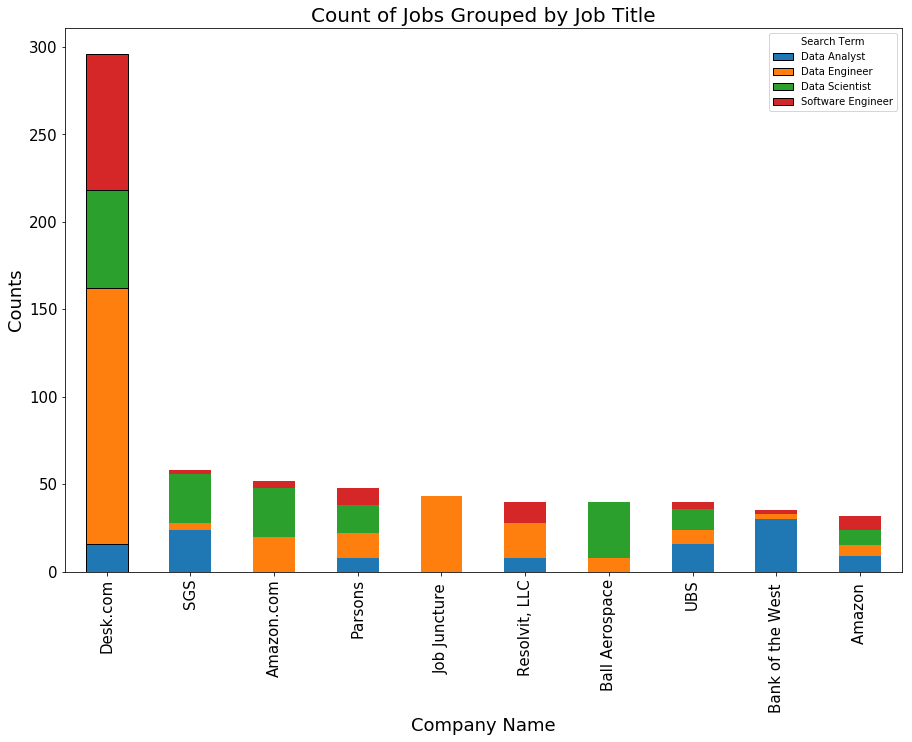

In [27]:
#Grouping Company name with the search term
dataframe = df.groupby(['Company Name', 'Search Term'])['Search Term'].count().unstack('Search Term').fillna(0)

#Calculating sum of each company and sorting the count to extract top 10 companies
dataframe['Sum']=(dataframe.sum(axis=1))
dataframe = dataframe.sort_values('Sum',ascending=False)[:10]

#Removing the last sum column
dataframe= dataframe.iloc[:, :-1]

#Plotting the graph
graph = dataframe.loc[:,dataframe.columns].plot.bar(stacked=True, figsize=(15,10), edgecolor="black" ,
                                                   fontsize = 15);
graph.set_xlabel('Company Name', fontsize = 18);
graph.set_ylabel('Counts', fontsize = 18);
graph.set_title('Count of Jobs Grouped by Job Title', fontsize = 20);

### 2. Bar Plot showing the number of jobs based on each search term.

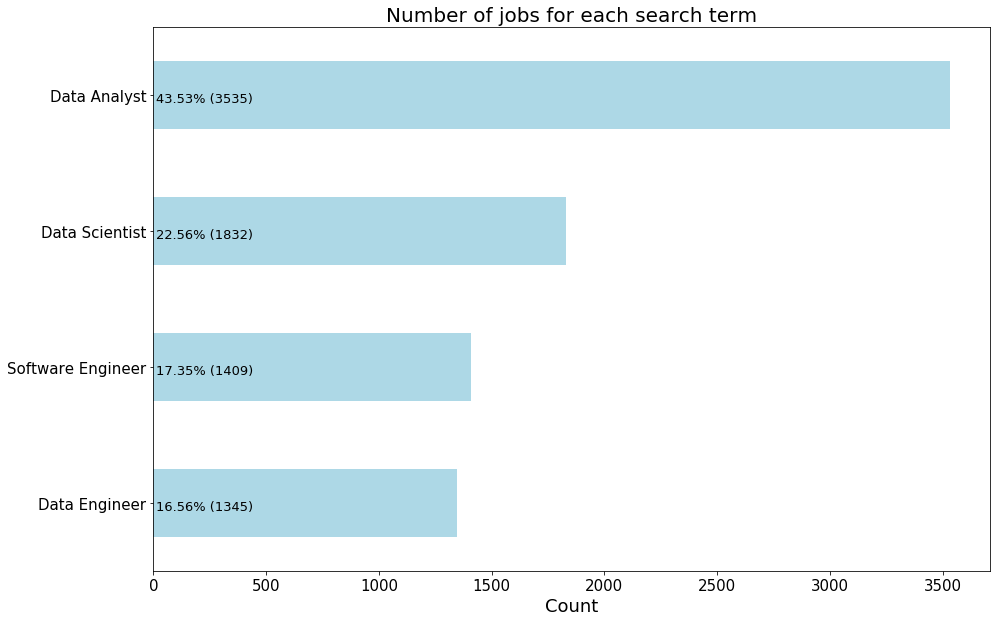

In [28]:
y = df['Search Term'];

graph = y.value_counts().plot(kind='barh', figsize=(15,10),fontsize=15, color="lightblue");
graph.set_xlabel('Count', fontsize = 18);
graph.set_title('Number of jobs for each search term', fontsize = 20);

#Create empty list to store totals
totals = []

#Find the values and append to list
for i in graph.patches:
    totals.append(i.get_width())

#Compute the total
total = sum(totals)

#Set individual bar labels using above list
for i in graph.patches:
    graph.text(10, i.get_y()+0.3, \
            str(round((i.get_width()/total)*100, 2))+'% (' + str(i.get_width()) + ')', fontsize=13, color='black')
# Making largest to go on top
graph.invert_yaxis()

### 3. Multi bar plot showing the number of jobs from each source i.e Indeed Vs Glassdoor.

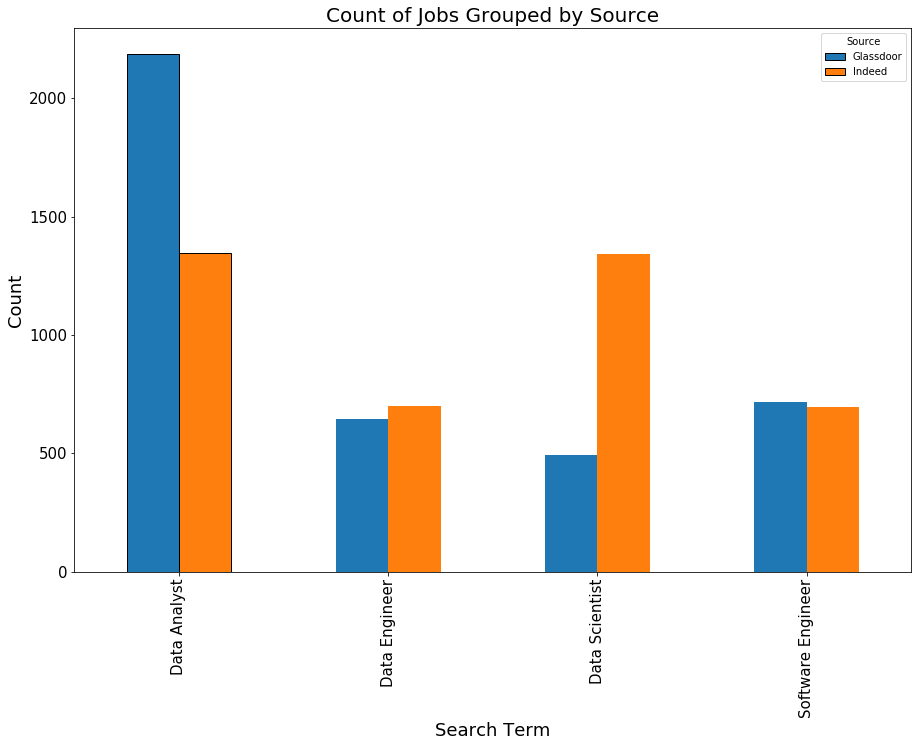

In [29]:
#Grouping Search term with the Source
dataframe = df.groupby(['Search Term', 'Source'])['Source'].count().unstack('Source').fillna(0)

#Plotting the graph
graph = dataframe.loc[:,dataframe.columns].plot.bar(figsize=(15,10), edgecolor="black", fontsize = 15);
graph.set_xlabel('Search Term', fontsize = 18);
graph.set_ylabel('Count', fontsize = 18);
graph.set_title('Count of Jobs Grouped by Source', fontsize = 20);

### 4. Pie chart showing % of jobs in top 10 locations.

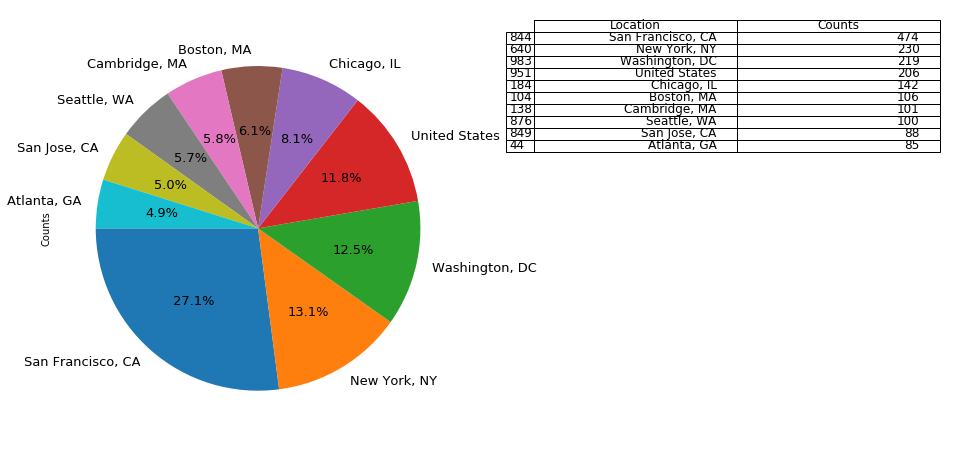

In [30]:
#Extracting counts based on Location
dataframe= df.groupby(['Location']).size().reset_index(name='Counts')
dataframe= dataframe.sort_values('Counts',ascending=False)[:10]
plt.figure(figsize=(16,8))

#Plot chart
ax1 = plt.subplot(121, aspect='equal')
dataframe.plot(kind='pie', y = 'Counts', ax=ax1, autopct='%1.1f%%', 
 startangle=180, shadow=False, labels=dataframe['Location'], legend = False, fontsize=13);

#Plot table
ax2 = plt.subplot(122)
plt.axis('off')
tbl = table(ax2, dataframe, loc='best')
tbl.set_fontsize(12)
plt.show()

### Clean the salary field. 

In [31]:
#Filter out records where salary is null
salaries = df[df.Salary.notnull()]

# For our analysis we are considering only yearly salaries. 
# Therefore we filter out hourly, weekly and daily salary ranges.
salaries = salaries[(~salaries.Salary.str.contains('hour')) & (~salaries.Salary.str.contains('a month'))
                   & (~salaries.Salary.str.contains('a week')) & (~salaries.Salary.str.contains('a day'))]

# Replace salaries containing 'a year' with space, 'k' with '000' and remove , and $
salaries.Salary = salaries.Salary.str.replace('a year', '').str.replace(',', '').str.replace('$', '').str.replace('k', '000 ')


new_salaries = [] #Create empty list to store cleaned salary values

# Compute mean of salary when salary ranges are present and append to list else append salary. 
for i in salaries.Salary:
    a = i.split('-')
    if len(a) == 2:
        new_salaries.append(np.mean([float(b) for b in a]))
    else:
        new_salaries.append(float(a[0]))
        
# Replace salary field with the new salaries list        
salaries.Salary = new_salaries

### 5. Histogram of Salary 

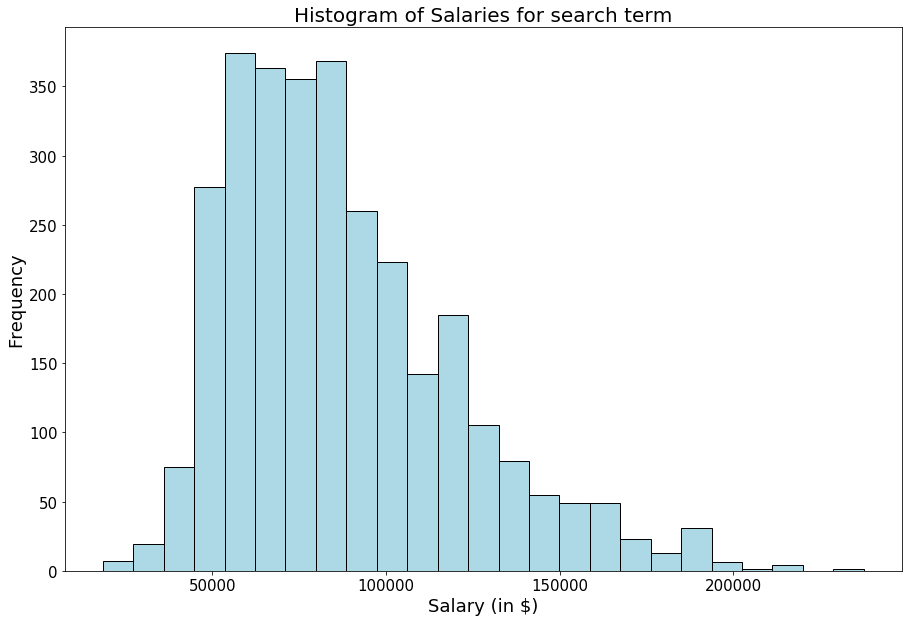

In [33]:
y = salaries['Salary'];
graph = y.plot(kind='hist', figsize=(15,10), color="lightblue", fontsize=15, edgecolor="black", bins = 25);
graph.set_xlabel('Salary (in $)', fontsize = 18);
graph.set_ylabel('Frequency', fontsize = 18);
graph.set_title("Histogram of Salaries for search term", fontsize = 20);



## Part 3: Build a classification model that will classify in which category (High, Medium, Low) salary will fall into. 

### Create a new field 'Salary_Range' of categorical type in the dataframe which indicates in which category the salary field falls into. 

In [34]:
salary_range = [] #Create empty list

# Segregate salary into High, Medium and Low ranges
for i in salaries.Salary:
    if i >= 100000:
        salary_range.append('High')
    elif i>50000 and i<100000:
        salary_range.append('Medium')
    else:
         salary_range.append('Low')

salaries['Salary_Range'] = salary_range #Add new column to salaries dataframe

### Convert every categorical input field into numeric field.

In [35]:
le = preprocessing.LabelEncoder() # Create an object of label encoder

#Transform every input fields
source = le.fit_transform(salaries.Source)
search_term = le.fit_transform(salaries['Search Term'])
job_title = le.fit_transform(salaries['Job Title'])
company = le.fit_transform(salaries['Company Name'])
location = le.fit_transform(salaries.Location)

In [36]:
# Replace the original fields with the new encoded fields
salaries['Source'] = source
salaries['Search Term'] = search_term
salaries['Job Title'] = job_title
salaries['Company Name'] = company
salaries['Location'] = location

### Fit Logistic Regression model

In [41]:
x = salaries.iloc[:,0:5]  #Store input variables
y = salaries['Salary_Range']  #Store the output variable which we are predicting

#Split the data into train and test sets (30% test set and 70% train set)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=0) 

#Create an abject of Logistic Regression function
logreg = LogisticRegression()

#Fit the model on the train set
logreg.fit(x_train, y_train)

#Predict the output using the model on the test set inputs
y_pred = logreg.predict(x_test)

#Perform K-fold cross validation 
kfold = model_selection.KFold(n_splits=10, random_state=9)
results = model_selection.cross_val_score(logreg, x_train, y_train, cv=kfold, scoring='accuracy')
print("10-fold cross validation average accuracy: %.3f" % (results.mean()))

10-fold cross validation average accuracy: 0.625


In [42]:
from sklearn.metrics import confusion_matrix

#Get the confusion matrix
confusion_matrix = confusion_matrix(y_test, y_pred)

#Print the confusion matrix table
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,High,Medium,All
True,,,
High,86,175,261
Low,2,69,71
Medium,82,506,588
All,170,750,920


### Fit Naive Bayes model

In [43]:
x = salaries.iloc[:,0:5]
y = salaries['Salary_Range']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=0)

gnb = GaussianNB()
gnb.fit(x_train, y_train)
y_pred = gnb.predict(x_test)

kfold = model_selection.KFold(n_splits=10, random_state=7)

results = model_selection.cross_val_score(gnb, x_train, y_train, cv=kfold, scoring='accuracy')
print("10-fold cross validation average accuracy: %.3f" % (results.mean()))

10-fold cross validation average accuracy: 0.636


In [44]:
from sklearn.metrics import confusion_matrix

#Get the confusion matrix
confusion_matrix = confusion_matrix(y_test, y_pred)

#Print the confusion matrix table
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)


Predicted,High,Low,Medium,All
True,,,,
High,104,0,157,261
Low,2,3,66,71
Medium,92,4,492,588
All,198,7,715,920
